In [6]:
%load_ext autoreload
%autoreload 2

In [1]:
import anndata as ad
import os
import scanpy as sc
import poisson_atac as patac
import pandas as pd

Global seed set to 0


In [2]:
! which python

/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/bin/python


In [7]:
adata = patac.data.load_aerts(convert_counts=False)

In [8]:
adata

AnnData object with n_obs × n_vars = 240919 × 129078
    obs: 'orig.ident', 'nCount_ATAC', 'nFeature_ATAC', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters', 'cell_id', 'is__cell_barcode', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'sample_barcode'
    layers: 'counts'

In [14]:
adata.layers['counts'].data.min()

1.0

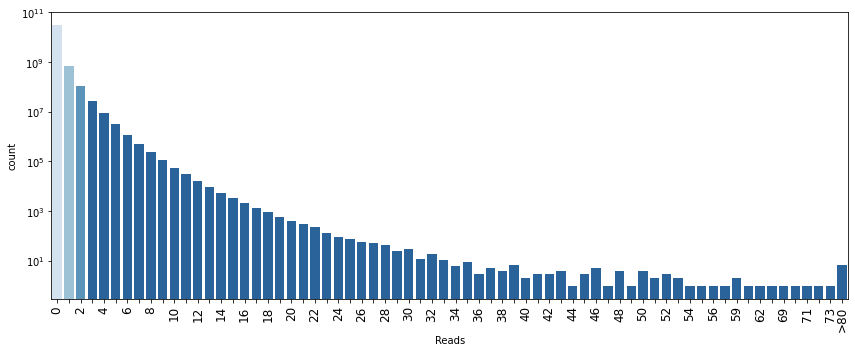

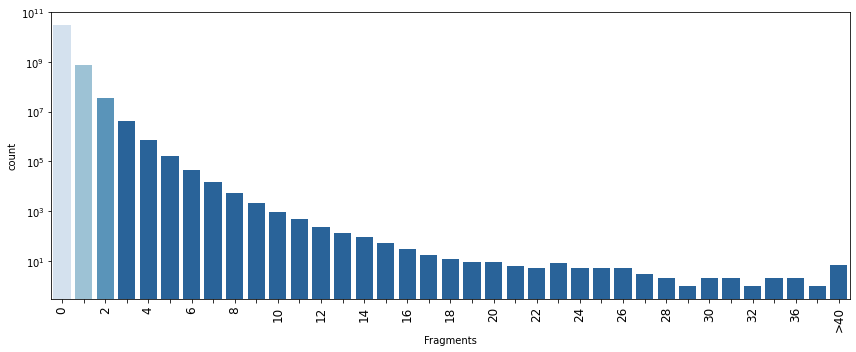

In [11]:
patac.pl.count_distribution(adata, figsize=(12, 5), limit=80, layer='counts')

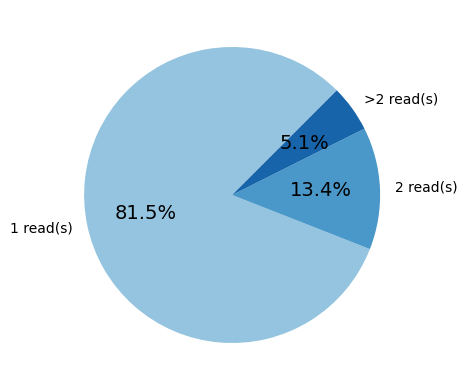

In [15]:
patac.pl.proportions(adata, lower_limit=1, upper_limit=1, layer="counts")

# Try cisTopic

In [86]:
.libPaths(c("~/miniconda3/envs/archr/lib/R/library", "~/miniconda3/envs/signac/lib/R/library"))
library(cisTopic)
library(stringr)
library(data.table)
library(Signac)
library(Seurat)
library(GenomeInfoDb)

cistopic <- readRDS('/lustre/groups/ml01/workspace/laura.martens/data/aerts_fly_brain/AllTimepoints_cisTopic.Rds')

peaks <- cistopic@region.ranges

seqlevelsStyle(peaks) <- "NCBI"

files <- list.files('/lustre/groups/ml01/workspace/laura.martens/data/aerts_fly_brain/cellRanger')

In [126]:
files

[1] "DFB__127e2f__DGRP_mix_DG2_Hyb-D15-D63-28278_white_pupae_12_hours"
 [2] "DFB__2b777e__10x_scATAC_DG2_pupal_brain_24_APF"                  
 [3] "DFB__2c5b14__DGRP_mix_DG2_Hyb-D15-D63-28278_4000k_cells"         
 [4] "DFB__303662__10x_scATAC_DG2_larval_brain"                        
 [5] "DFB__46d13d__10x_scATAC_Mix_DGRP_pupal_brain_48_APF"             
 [6] "DFB__4e2bbb__DGRP_mix_DG2_Hyb-D15-D63-28278_white_pupae_3_hours" 
 [7] "DFB__59b45b__DGRP_mix_DG2_Hyb-D15-D63-28278_6000k_cells"         
 [8] "DFB__5e8b4e__DGRP_mix_DG2_Hyb-D15-D63-28278_white_pupae_6_hours" 
 [9] "DFB__6d6d0c__10x_scATAC_DG2_pupal_brain_24_APF"                  
[10] "DFB__7bc63d__DGRP_mix_DG2_Hyb-D15-D63-28278_8000k_cells"         
[11] "DFB__8569df__DGRP_mix_DG2_Hyb-D15-D63-28278_white_pupae_0_hours" 
[12] "DFB__8f8273__DGRP_mix_DG2_Hyb-D15-D63-28278_white_pupae_3_hours" 
[13] "DFB__96a6e8__10x_scATAC_DG2_larval_brain"                        
[14] "DFB__9ed3fa__DGRP_mix_DG2_Hyb-D15-D63-28278_white_pupae_6_hours" 
[15] "DFB__a2d857__DGRP_mix_DG2_Hyb-D15-D63-28278_white_pupae_12_hours"
[16] "DFB__c0f875__10x_scATAC_Mix_DGRP_pupal_brain_72_APF"             
[17] "DFB__c62f88__DGRP_mix_DG2_Hyb-D15-D63-28278_2000k_cells"         
[18] "DFB__e26179__DGRP_mix_DG2_Hyb-D15-D63-28278_white_pupae_0_hours" 
[19] "DFB__e80c42__10x_scATAC_Mix_DGRP_pupal_brain_48_APF"             
[20] "DFB__f13919__10x_scATAC_Mix_DGRP_pupal_brain_72_APF"             
[21] "EAD__0f50f9__10x_scATAC_DG2_eye_antennal_disks"                  
[22] "EAD__79d3d8__10x_scATAC_DG2_eye_antennal_disks"                  
[23] "FDM__1d60cb__10x_scATAC_mix_DGRP_adult_central_brain"            
[24] "FDM__9c338b__10x_scATAC_mix_DGRP_adult_central_brain"            
[25] "FDM__f2501a__10x_scATAC_mix_DGRP_adult_brain"

In [86]:
# load metadata
ids <- list()
objects <- list()
for(sample in files[20:length(files)]){
    print(sample)
    id <- substr(sample, 9, 11)
    print(id)
    sample_path = paste0('/lustre/groups/ml01/workspace/laura.martens/data/aerts_fly_brain/cellRanger/', sample)
    metadata <- read.table(
      file = paste0(sample_path, '/singlecell.csv'),
      stringsAsFactors = FALSE,
      sep = ",",
      header = TRUE,
      row.names = 1
    )[-1, ] # remove the first row
    metadata$sample_barcode <- str_c(id,rownames(metadata), sep='.')
    metadata <- metadata[metadata$sample_barcode %in% cistopic@cell.names,]
    
    if(nrow(metadata) == 0){
        next
    }
    frags <- CreateFragmentObject(
      path = paste0(sample_path, "/fragments.tsv.gz"),
      cells = rownames(metadata)
    )
    counts <- FeatureMatrix(
  fragments = frags,
  features = peaks,
  cells = rownames(metadata)
        
)
    atac_assay <- CreateChromatinAssay(counts, fragments = frags)
    atac <- CreateSeuratObject(atac_assay, assay = "ATAC", meta.data=metadata)
    
    objects[id] <- atac
    ids[id] <- id
    }

combined <- merge(
  x = objects[1],
  y = objects[2:length(objects)],
  add.cell.ids = ids
)

saveRDS(combined, '/lustre/groups/ml01/workspace/laura.martens/data/aerts_fly_brain/All_timepoints.rds')

In [ ]:
counts